# 06

In [ ]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_MMGLR_deep/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_MMGLR_deep/checkpoints/")
VERBOSE_RATE = 1000

(H_train, W_train) = (128, 128)
(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 996)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_train,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

validation_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/CBSD68_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_val,
    patch_overlap_size=W_val//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

test_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    patch_size=H_test,
    patch_overlap_size=0,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


data_train_batched = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, num_workers=4
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=16, num_workers=4
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=4
)

In [ ]:
import itertools
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.profiler import profile, record_function, ProfilerActivity
# torch.set_default_dtype(torch.float64)

from einops import rearrange


class CustomLayerNorm(nn.Module):
    def __init__(self, nchannels):
        super(CustomLayerNorm, self).__init__()
        
        self.nchannels = nchannels
        self.weighted_transform = nn.Conv2d(nchannels, nchannels, kernel_size=1, stride=1, groups=nchannels, bias=False)

    def forward(self, x):
        # bz, nchannels, h, w = x.shape
        sigma = x.var(dim=1, keepdim=True, correction=1)
        # bz, 1, h, w = sigma.shape
        return self.weighted_transform(x / torch.sqrt(sigma+1e-5))
    


##########################################################################
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)
        # hidden_features = dim

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = nn.functional.gelu(x1) * x2
        x = self.project_out(x)
        return x


##########################################################################
class FFBlock(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FFBlock, self).__init__()

        self.norm = CustomLayerNorm(dim)

        self.skip_connect_weight_final = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = self.skip_connect_weight_final[0]*x + self.skip_connect_weight_final[1]*self.ffn(self.norm(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x



##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)

##########################################################################
class FeatureExtraction(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=48, 
        dim = 48,
        num_blocks = [1,2,2,4], 
        num_refinement_blocks = 4,
        ffn_expansion_factor = 2.66,
        bias = False,
    ):

        super(FeatureExtraction, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[FFBlock(dim=dim, ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
        self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3
        self.encoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim*2**2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[FFBlock(dim=int(dim*2**3), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[3])])
        
        self.up4_3 = Upsample(int(dim*2**3)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2**3), int(dim*2**2), kernel_size=1, bias=bias)
        self.decoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim*2**2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])


        self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_refinement_blocks)])

        ###########################
        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):

        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3) 

        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4) 
                        
        inp_dec_level3 = self.up4_3(latent)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3) 

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2) 

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)
        out_dec_level1 = self.output(out_dec_level1)

        # return [latent, out_dec_level3, out_dec_level2, out_dec_level1]
        return [out_dec_level1, out_dec_level2, out_dec_level3, latent]


class GLRFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GLRFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )


    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        neighbors_pixels = []
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            neighbors_pixels.append(
                img_features_frame[:, :, fromh:toh, fromw:tow]
            )
        neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        return edge_weights_norm, node_degree
    


    def op_L_norm(self, img_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Wx = torch.einsum(
            "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
        )
        output = img_signals - Wx
        return output

    def forward(self, patchs, edge_weights, node_degree):
        output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)
        return output_patchs
    



class GTVFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GTVFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )
        ############
        # avg_kernel = 1.0 * torch.tensor([
        #     [0.0, 0.0, 0.0],
        #     [0.0, 1.0, 0.0],
        #     [0.0, 0.0, 0.0],
        # ])
        # kernel = []
        # for r in range(self.n_channels):
        #     kernel.append(avg_kernel[np.newaxis, np.newaxis, :, :])

        # kernel = torch.concat(kernel, axis=0).to(self.device)
        # self.stats_kernel = Parameter(
        #     torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel,
        #     requires_grad=True,
        # )

    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        neighbors_pixels = []
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            neighbors_pixels.append(
                img_features_frame[:, :, fromh:toh, fromw:tow]
            )
        neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        return edge_weights_norm, node_degree
    
    # def stats_conv(self, patchs):
    #     batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
    #     temp_patch = patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
    #     temp_patch = nn.functional.pad(temp_patch, (1,1,1,1), 'reflect')
    #     temp_out_patch = nn.functional.conv2d(
    #         temp_patch,
    #         weight=self.stats_kernel,
    #         stride=1,
    #         padding=0,
    #         dilation=1,
    #         groups=self.n_channels,
    #     )
    #     out_patch = temp_out_patch.view(batch_size, n_graphs, c_size, h_size, w_size)
    #     return out_patch

    # def stats_conv_transpose(self, patchs):
    #     batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
    #     temp_patch = patchs.reshape(batch_size*n_graphs, c_size, h_size, w_size)
    #     temp_out_patch = nn.functional.conv_transpose2d(
    #         temp_patch,
    #         weight=self.stats_kernel,
    #         stride=1,
    #         padding=1,
    #         dilation=1,
    #         groups=self.n_channels,
    #     )
    #     out_patch = temp_out_patch.view(batch_size, n_graphs, c_size, h_size, h_size)
    #     return out_patch

    def op_C(self, img_signals, edge_weights, node_degree):


        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        # img_signals = self.stats_conv(img_signals)

        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Cx1 = img_signals[:, :, :, None, :, :] * edge_weights[:, :, None, :, :, :]
        Cx2 = img_features_neighbors * edge_weights[:, :, None, :, :, :]
        
        output = Cx1 - Cx2

        return output
    
    def op_C_transpose(self, edge_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, n_edges, H, W = edge_signals.shape
        edge_signals = edge_signals * edge_weights[:, :, None, :, :, :]

        output = edge_signals.sum(axis=3)

        padH, padW = self.pad_dim_hw
        output = nn.functional.pad(
            output.view(batch_size, n_graphs*n_channels, H, W),
            (padW, padW, padH, padH), "replicate"
        ).view(batch_size, n_graphs, n_channels, H + 2*padH, W + 2*padW)

        i=0
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            output[:, :, :, fromh:toh, fromw:tow] = output[:, :, :, fromh:toh, fromw:tow] - edge_signals[:, :, :, i, :, :]
            i+=1

        output = output[:, :, :, padH:-padH, padW:-padW]

        # output = self.stats_conv_transpose(output)
        return output

    def forward(self, patchs, edge_weights, node_degree):
        # C^T C
        edges_signals = self.op_C(patchs, edge_weights, node_degree)
        output_patchs = self.op_C_transpose(edges_signals, edge_weights, node_degree)

        return output_patchs
    
class MixtureGTV(nn.Module):
    def __init__(self, 
            nchannels_in,
            n_graphs,
            n_node_fts,
            connection_window,
            n_cgd_iters,
            alpha_init,
            beta_init,
            muy_init, ro_init, gamma_init,
            device
        ):
        super(MixtureGTV, self).__init__()

        self.device       = device
        self.n_graphs     = n_graphs
        self.n_node_fts   = n_node_fts
        self.n_total_fts  = n_graphs * n_node_fts
        self.n_levels     = 4
        self.n_cgd_iters  = n_cgd_iters
        self.nchannels_in = nchannels_in
        self.connection_window = connection_window

        self.alphaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * alpha_init,
            requires_grad=True
        )

        self.betaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * beta_init,
            requires_grad=True
        )

        self.patchs_features_extraction = FeatureExtraction(
            inp_channels=3, 
            out_channels=self.n_total_fts, 
            dim = self.n_total_fts,
            num_blocks = [2, 2, 2, 2], 
            num_refinement_blocks = 4,
            ffn_expansion_factor = 1,
            bias = False,
        ).to(self.device)
        
        self.combination_weight = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_total_fts, 
                out_channels=self.n_graphs, 
                kernel_size=1,
                stride=1,
                padding=0,
                padding_mode="zeros",
                bias=False
            ),
            nn.Softmax(dim=1)
        ).to(self.device)

        self.ro00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * ro_init[0],
            requires_grad=True,
        )
        self.gamma00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * torch.log(gamma_init[0]),
            requires_grad=True,
        )
        self.GTVmodule00 = GTVFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )

        self.muys00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * muy_init[0],
            requires_grad=True,
        )
        self.GLRmodule00 = GLRFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )

    def apply_lightweight_transformer(self, patchs, list_graph_weightGTV, list_graph_weightGLR):

        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape 
        patchs = patchs.contiguous()
        graph_weights, graph_degree = list_graph_weightGLR[0]

        Lpatchs = self.GLRmodule00(patchs, graph_weights, graph_degree)
        Lpatchs = torch.einsum(
            "bHchw, H -> bHchw", Lpatchs, self.muys00
        )

        graph_weights, graph_degree = list_graph_weightGTV[0]
        CtCpatchs = self.GTVmodule00(patchs, graph_weights, graph_degree)
        CtCpatchs = torch.einsum(
            "bHchw, H -> bHchw", CtCpatchs, self.ro00
        )

        output = patchs + Lpatchs + CtCpatchs

        return output
    
    def soft_threshold(self, delta, gamma):
        # batch_size, n_graphs, n_channels, n_edges, H, W = delta.shape
        # n_graphs = gamma.shape

        gamma = gamma[None, :, None, None, None, None]
        # print(f"Gamma.shape={gamma.shape}")

        condA = (delta < -gamma) 
        outputA = torch.where(
            condA,
            delta+gamma,
            0.0
        )
        condB = (delta > gamma) 
        outputB = torch.where(
            condB,
            delta-gamma,
            0.0
        )
        output = outputA + outputB
        return output


    def forward(self, patchs):
        # with record_function("MultiScaleMixtureGLR:forward"): 
        # print("#"*80)
        # patchs = patchs.permute(dims=(0, 3, 1, 2))
        # patchs = patchs.contiguous()
        # patchs = self.images_domain_to_abtract_domain(patchs)
        # print(f"patchs.shape={patchs.shape}")
        batch_size, c_size, h_size, w_size = patchs.shape

        #####
        ## Graph low pass filter
        
        list_features_patchs = self.patchs_features_extraction(patchs)
        list_graph_weightGTV = [None] * self.n_levels
        list_graph_weightGLR = [None] * self.n_levels
        bz, nfts, h, w = list_features_patchs[0].shape

        list_graph_weightGTV[0] = self.GTVmodule00.extract_edge_weights(
            list_features_patchs[0].view((bz, self.GTVmodule00.n_graphs, self.GTVmodule00.n_node_fts, h, w))
        )
        list_graph_weightGLR[0] = self.GLRmodule00.extract_edge_weights(
            list_features_patchs[0].view((bz, self.GLRmodule00.n_graphs, self.GLRmodule00.n_node_fts, h, w))
        )

        epsilon = self.GTVmodule00.op_C(patchs[:, None, :, :, :], list_graph_weightGTV[0][0], list_graph_weightGTV[0][1])
        bias    = torch.zeros_like(epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += patchs[:, None, :, :, :]
        ############################################################
        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[0, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[1, None, :, None, None, None] * update
        output = output + self.alphaCGD[1, None, :, None, None, None] * update

        epsilon = self.soft_threshold(
            self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) + bias,
            torch.exp(self.gamma00)
        )
        bias  = bias + (self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) - epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += patchs[:, None, :, :, :]
        ############################################################

        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[2, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[3, None, :, None, None, None] * update
        output = output + self.alphaCGD[3, None, :, None, None, None] * update

        epsilon = self.soft_threshold(
            self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) + bias,
            torch.exp(self.gamma00)
        )
        bias  = bias + (self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) - epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += patchs[:, None, :, :, :]
        ############################################################

        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[4, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[5, None, :, None, None, None] * update
        output = output + self.alphaCGD[5, None, :, None, None, None] * update
        

        score = self.combination_weight(list_features_patchs[0])
        output = torch.einsum(
            "bgchw, bghw -> bchw", output, score
        )

        return output

    

#########################################################################
class SharpeningBlock(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_features):
        super(SharpeningBlock, self).__init__()

        self.project_in = nn.Conv2d(dim_in, hidden_features*2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=False)
        self.project_out = nn.Conv2d(hidden_features, dim_out, kernel_size=1, bias=False)
        self.skip_connect_weight = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        
    def forward(self, patchs):

        out = self.project_in(patchs)
        out01, out02 = self.dwconv(out).chunk(2, dim=1)
        out = nn.functional.gelu(out01) * out02
        out = self.project_out(out)
        out = self.skip_connect_weight[0] * patchs + self.skip_connect_weight[1] * out
        return out
##########################################################################
# class SharpeningBlock(nn.Module):
#     def __init__(self, dim_in):
#         super(SharpeningBlock, self).__init__()
#         ###########
#         sharp_kernel = 1.0 * torch.tensor([
#             [0.0, -1.0, 0.0],
#             [-1.0, 5.0, -1.0],
#             [0.0, -1.0, 0.0],
#         ])
#         kernel = []
#         for r in range(dim_in):
#             kernel.append(sharp_kernel[np.newaxis, np.newaxis, :, :])
#         kernel = torch.concat(kernel, axis=0)
#         self.sharpening_kernel = Parameter(
#             torch.ones((dim_in, 1, 3, 3), dtype=torch.float32) * kernel,
#             requires_grad=True,
#         )
#         self.skip_connect_weight = Parameter(
#             torch.ones((2), dtype=torch.float32) * torch.tensor([0.9, 0.1]),
#             requires_grad=True
#         )

#     def forward(self, patchs):
#         out = nn.functional.conv2d(
#             patchs,
#             weight=self.sharpening_kernel,
#             stride=1,
#             padding=1,
#             dilation=1,
#             groups=3,
#         )
#         out = self.skip_connect_weight[0] * patchs + self.skip_connect_weight[1] * out
#         return out



class MultiScaleSequenceDenoiser(nn.Module):
    def __init__(self, device):
        super(MultiScaleSequenceDenoiser, self).__init__()
        self.device = device

        CONNECTION_FLAGS_3x3= np.array([
            1,1,1,
            1,0,1,
            1,1,1,
        ]).reshape((3,3))

        CONNECTION_FLAGS_5x5 = np.array([
            1,1,1,1,1,
            1,1,1,1,1,
            1,1,0,1,1,
            1,1,1,1,1,
            1,1,1,1,1,
        ]).reshape((5,5))

        self.skip_connect_weight_01 = Parameter(
            torch.ones((2), dtype=torch.float32, device=device) * torch.tensor([0.1, 0.9]).to(device),
            requires_grad=True
        )
        self.mixtureGLR_block01 = MixtureGTV(
            nchannels_in=3,
            n_graphs=4,
            n_node_fts=6,
            connection_window=CONNECTION_FLAGS_3x3,
            n_cgd_iters=6,
            alpha_init=0.5,
            beta_init=0.1,
            muy_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(self.device),
            device=self.device
        )
        self.sharp01 = SharpeningBlock(3, 3, 24).to(device)
        

        self.skip_connect_weight_02 = Parameter(
            torch.ones((2), dtype=torch.float32, device=device) * torch.tensor([0.1, 0.9]).to(device),
            requires_grad=True
        )
        self.mixtureGLR_block02 = MixtureGTV(
            nchannels_in=3,
            n_graphs=4,
            n_node_fts=6,
            connection_window=CONNECTION_FLAGS_3x3,
            n_cgd_iters=6,
            alpha_init=0.5,
            beta_init=0.1,
            muy_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(self.device),
            device=self.device
        )
        self.sharp02 = SharpeningBlock(3, 3, 24).to(device)
        

        self.skip_connect_weight_03 = Parameter(
            torch.ones((2), dtype=torch.float32, device=self.device) * torch.tensor([0.1, 0.9]).to(device),
            requires_grad=True
        )
        self.mixtureGLR_block03 = MixtureGTV(
            nchannels_in=3,
            n_graphs=4,
            n_node_fts=12,
            connection_window=CONNECTION_FLAGS_5x5,
            n_cgd_iters=6,
            alpha_init=0.5,
            beta_init=0.1,
            muy_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(self.device),
            device=self.device
        )
        self.sharp03 = SharpeningBlock(3, 3, 24).to(device)
        
    
    def forward(self, patchs):

        output = self.skip_connect_weight_01[0] * patchs + self.skip_connect_weight_01[1] * self.sharp01(self.mixtureGLR_block01(patchs))
        output = self.skip_connect_weight_02[0] * output + self.skip_connect_weight_02[1] * self.sharp02(self.mixtureGLR_block02(output))
        output = self.skip_connect_weight_03[0] * output + self.skip_connect_weight_03[1] * self.sharp03(self.mixtureGLR_block03(output))

        # output   = self.mixtureGLR_block01(patchs)
        # output = self.skip_connect_weight_01[0] * (patchs-output) + self.skip_connect_weight_01[1] * output

        # output   = self.mixtureGLR_block02(output)
        # output = self.skip_connect_weight_02[0] * (patchs-output) + self.skip_connect_weight_02[1] * output
        
        # output   = self.mixtureGLR_block03(output)
        # output = self.skip_connect_weight_03[0] * (patchs-output) + self.skip_connect_weight_03[1] * output

        return output

In [ ]:

# CONNECTION_FLAGS = np.array([
#     1,1,1,
#     1,0,1,
#     1,1,1,
# ]).reshape((3,3))

CONNECTION_FLAGS = np.array([
    1,1,1,1,1,
    1,1,1,1,1,
    1,1,0,1,1,
    1,1,1,1,1,
    1,1,1,1,1,
]).reshape((5,5))


# model = MixtureGTV(
#     nchannels_in=3,
#     n_graphs=4,
#     n_node_fts=12,
#     connection_window=CONNECTION_FLAGS,
#     n_cgd_iters=6,
#     alpha_init=0.5,
#     beta_init=0.1,
#     muy_init=torch.tensor([[0.1], [0.0], [0.1], [0.0]]).to(DEVICE),
#     ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(DEVICE),
#     gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(DEVICE),
#     device=DEVICE
# )

model = MultiScaleSequenceDenoiser(device=DEVICE)

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)
print(f"Init model with total parameters: {s}")


criterian = nn.L1Loss()
# criterian = nn.MSELoss()
# criterian = nn.HuberLoss(delta=0.03)
optimizer = Adam(
    model.parameters(),
    lr=0.001,
    eps=1e-08
)
lr_scheduler = MultiStepLR(
    optimizer,
    milestones=[100000, 200000, 300000, 400000, 500000], gamma=0.7
)

Init model with total parameters: 8282532


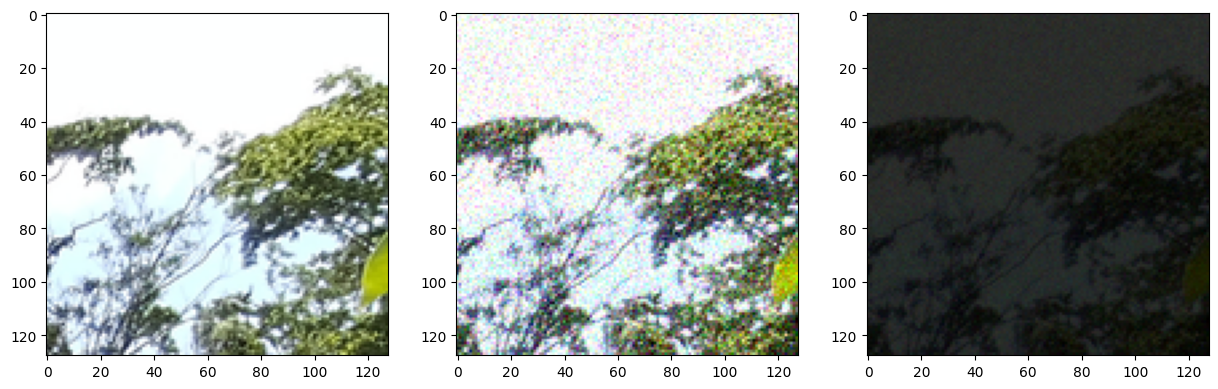

In [ ]:
for patchs_noisy, patchs_true in data_train_batched:
    # with torch.autograd.set_detect_anomaly(True):
    with torch.no_grad():
        patchs_noisy = patchs_noisy.to(DEVICE)
        patchs_true = patchs_true.to(DEVICE)
        reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    break


B = 2
img_true = np.clip(patchs_true[B].cpu().numpy(), a_min=0.0, a_max=100.0).astype(np.float64)
img_noisy = np.clip(patchs_noisy[B].cpu().numpy(), a_min=0.0, a_max=100.0).astype(np.float64)
img_recon = np.clip(reconstruct_patchs[B].cpu().numpy(), a_min=0.0, a_max=100.0).astype(np.float64)

fig, axs = plt.subplots( ncols=3, nrows=1, figsize=(15, 5))
axs[0].imshow(img_true)
axs[1].imshow(img_noisy)
axs[2].imshow(img_recon)
plt.show()

In [ ]:
# CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_GLT_GTV_deep/checkpoints/")
# training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0072k.pt')
# training_state = torch.load(training_state_path)
# model.load_state_dict(training_state["model"])

In [ ]:
i=0
for patchs_noisy, patchs_true in data_train_batched:
    # with torch.autograd.set_detect_anomaly(True):
    s = time.time()
    optimizer.zero_grad()
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE)
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    loss_value = criterian(reconstruct_patchs, patchs_true)
    loss_value.backward()
    optimizer.step()
    lr_scheduler.step()

    img_true = np.clip(patchs_true.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    img_recon = np.clip(reconstruct_patchs.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    train_mse_value = np.square(img_true- img_recon).mean()
    train_psnr = 10 * np.log10(1/train_mse_value)
    print(f"iter={i} time={time.time()-s} psnr={train_psnr} mse={train_mse_value}")
    i+=1

    if i == 5000:
        break

iter=0 time=0.9961121082305908 psnr=4.9212548796143665 mse=0.32201382085064795
iter=1 time=0.9659497737884521 psnr=4.981581147230902 mse=0.31757176683530836
iter=2 time=0.9620168209075928 psnr=7.280032098545504 mse=0.18706683142739644
iter=3 time=0.9629383087158203 psnr=4.9089552403360335 mse=0.3229270877190638
iter=4 time=0.9618210792541504 psnr=9.468381537443273 mse=0.11302170282761204


iter=5 time=0.9662890434265137 psnr=7.691868571072638 mse=0.17014263047529496
iter=6 time=0.9635822772979736 psnr=10.443458833229249 mse=0.09029300704960448
iter=7 time=0.9605824947357178 psnr=6.390389958636465 mse=0.229594248320934
iter=8 time=0.9643819332122803 psnr=7.77017503378853 mse=0.167102326567074
iter=9 time=0.960547924041748 psnr=9.03934808958583 mse=0.12475707704418798
iter=10 time=0.9620397090911865 psnr=8.080247848462344 mse=0.15558768363978268
iter=11 time=0.9639363288879395 psnr=7.914638416362477 mse=0.16163527943357928
iter=12 time=0.9638903141021729 psnr=13.6355385767767 mse=0.04329583724244304
iter=13 time=0.9633221626281738 psnr=7.231842252742617 mse=0.18915410673662356
iter=14 time=0.9623947143554688 psnr=7.9137290602081105 mse=0.16166912730215416
iter=15 time=0.9642729759216309 psnr=5.944368887937653 mse=0.25442694967689505
iter=16 time=0.9644250869750977 psnr=6.576520301123976 mse=0.21996215703257718
iter=17 time=0.9620957374572754 psnr=9.341095263933711 mse=0.11

In [ ]:
model.state_dict()

OrderedDict([('skip_connect_weight_01',
              tensor([0.2385, 1.0293], device='cuda:0')),
             ('skip_connect_weight_02',
              tensor([0.2720, 1.0420], device='cuda:0')),
             ('skip_connect_weight_03',
              tensor([0.2572, 1.0700], device='cuda:0')),
             ('mixtureGLR_block01.alphaCGD',
              tensor([[ 0.3463,  0.2781,  0.4461,  0.4250],
                      [ 1.0126,  1.1434,  0.8756,  1.2215],
                      [ 0.3288,  0.5613, -0.1298,  0.5640],
                      [ 1.2262,  1.0355,  1.5506,  1.0399],
                      [-0.0391,  0.0588, -0.0660,  0.0891],
                      [ 0.4555,  1.0871,  0.5878,  1.0768]], device='cuda:0')),
             ('mixtureGLR_block01.betaCGD',
              tensor([[0.1000, 0.1000, 0.1000, 0.1000],
                      [0.5551, 0.6843, 0.5867, 0.7046],
                      [0.1000, 0.1000, 0.1000, 0.1000],
                      [0.6923, 0.5448, 1.0727, 0.5689],
             

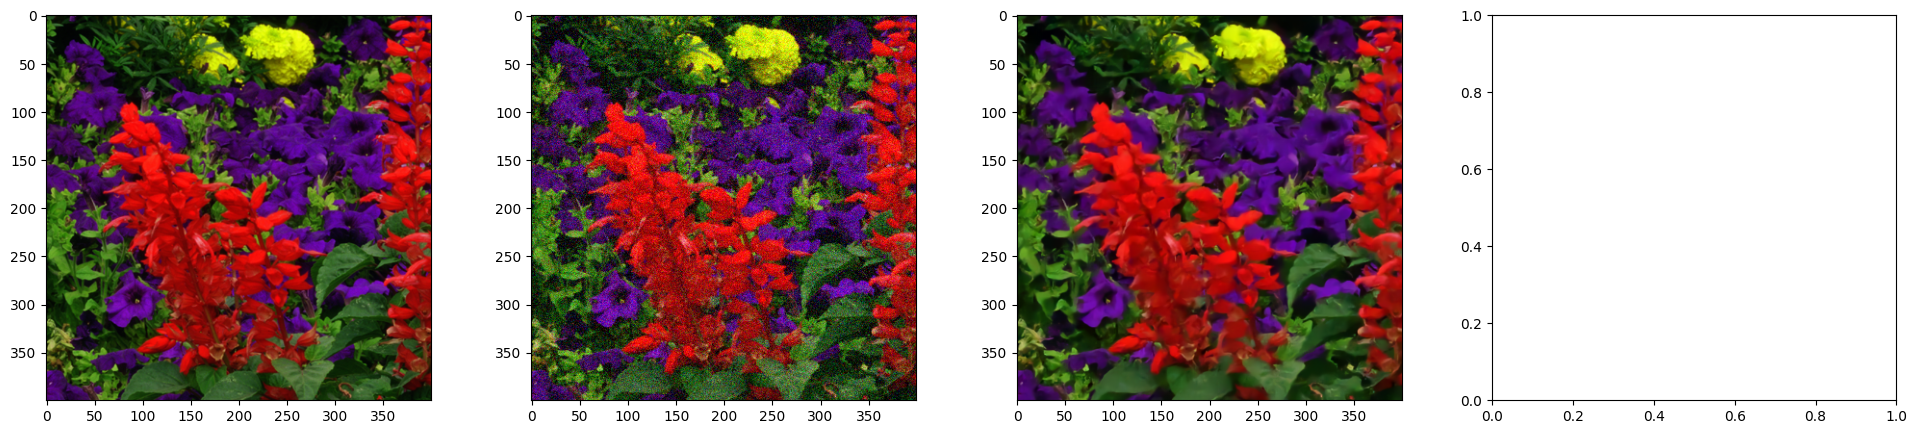

In [ ]:
k = 0
for patchs_noisy, patchs_true in data_test_batched:
    # with torch.autograd.set_detect_anomaly(True):
    with torch.no_grad():
        patchs_noisy = patchs_noisy.to(DEVICE)
        patchs_true = patchs_true.to(DEVICE)
        # reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    if k == 2:
        break
    k+=1

patchs = patchs_noisy.permute(0, 3, 1, 2)
# output = model.sharp01(model.mixtureGLR_block01(patchs))
output = model.skip_connect_weight_01[0] * patchs + model.skip_connect_weight_01[1] * model.sharp01(model.mixtureGLR_block01(patchs))
# output = model.sharp02(model.mixtureGLR_block02(output))
output = model.skip_connect_weight_02[0] * output + model.skip_connect_weight_02[1] * model.sharp02(model.mixtureGLR_block02(output))
# output = model.sharp03(model.mixtureGLR_block03(output))
output = model.skip_connect_weight_03[0] * output + model.skip_connect_weight_03[1] * model.sharp03(model.mixtureGLR_block03(output))
reconstruct_patchs01 = output.permute(0, 2, 3, 1).detach()

B = 0
f,t = 0,400

img_true = np.clip(patchs_true[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)
img_noisy = np.clip(patchs_noisy[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)
img_recon = np.clip(reconstruct_patchs01[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)

fig, axs = plt.subplots( ncols=4, nrows=1, figsize=(24, 5))
axs[0].imshow(img_true)
axs[1].imshow(img_noisy)
axs[2].imshow(img_recon)
plt.show()

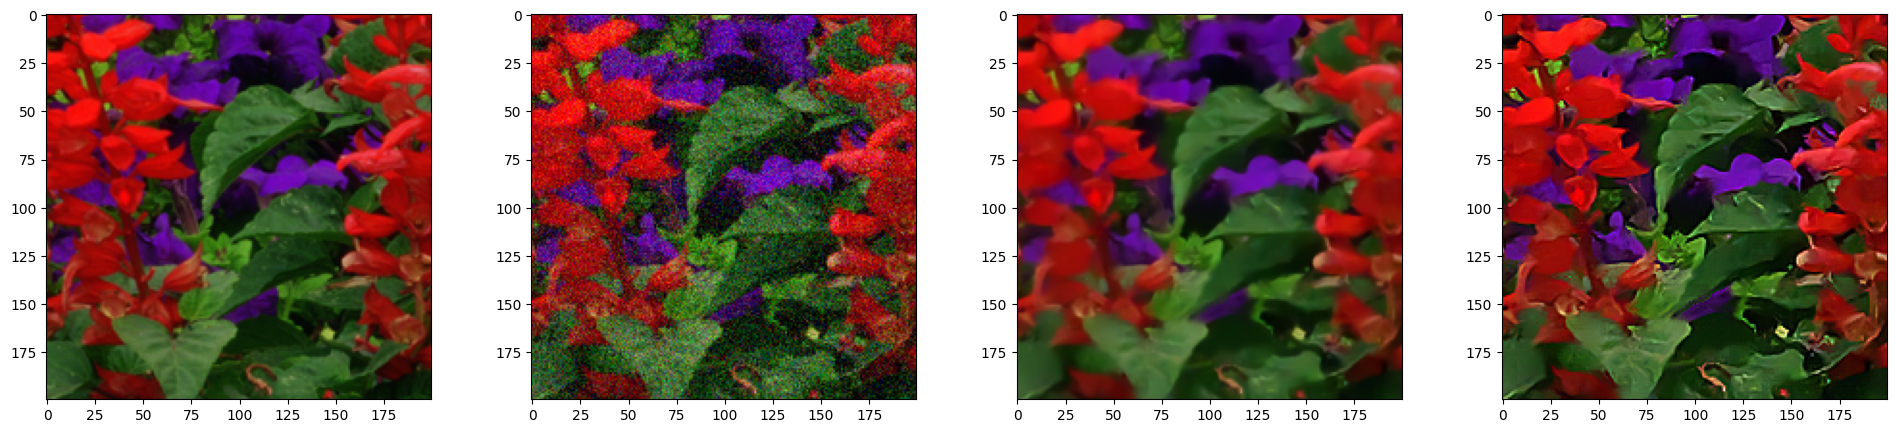

In [ ]:
k = 0
###########
avg_kernel = 1.0 * torch.tensor([
    [0.0, -1.0, 0.0],
    [-1.0, 5.0, -1.0],
    [0.0, -1.0, 0.0],
])
kernel = []
for r in range(3):
    kernel.append(avg_kernel[np.newaxis, np.newaxis, :, :])

kernel = torch.concat(kernel, axis=0).to(DEVICE)


for patchs_noisy, patchs_true in data_test_batched:
    # with torch.autograd.set_detect_anomaly(True):
    if k == 2:
        with torch.no_grad():
            patchs_noisy = patchs_noisy.to(DEVICE)
            patchs_true = patchs_true.to(DEVICE)
            reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
            reconstruct_patchs_sharped = nn.functional.conv2d(
                reconstruct_patchs.permute(0, 3, 1, 2),
                weight=kernel,
                stride=1,
                padding=0,
                dilation=1,
                groups=3,
            ).permute(0, 2, 3, 1)
        break
    else:
        k+=1
        continue


B = 0
f,t = 200,400

img_true = np.clip(patchs_true[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)
img_noisy = np.clip(patchs_noisy[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)
img_recon = np.clip(reconstruct_patchs[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)
img_recon2 = np.clip(reconstruct_patchs_sharped[B].cpu().numpy()[f:t, f:t], a_min=0.0, a_max=100.0).astype(np.float64)

fig, axs = plt.subplots( ncols=4, nrows=1, figsize=(24, 5))
axs[0].imshow(img_true)
axs[1].imshow(img_noisy)
axs[2].imshow(img_recon)
axs[3].imshow(img_recon2)
plt.show()

In [ ]:
test_mse_value = np.square(img_true- img_recon2).mean()
list_test_mse.append(test_mse_value)
print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")


test_i=18 time=631.2148439884186 test_i_psnr_value=20.321564352916152


In [ ]:
###########
avg_kernel = 1.0 * torch.tensor([
    [0.0, -1.0, 0.0],
    [-1.0, 5.0, -1.0],
    [0.0, -1.0, 0.0],
])
kernel = []
for r in range(3):
    kernel.append(avg_kernel[np.newaxis, np.newaxis, :, :])

kernel = torch.concat(kernel, axis=0).to(DEVICE)


In [ ]:
# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_noisy = np.clip(test_patchs_noisy[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")

        # fig, axs = plt.subplots( ncols=3, nrows=1, figsize=(15, 5))
        # axs[0].imshow(img_true)
        # axs[1].imshow(img_noisy)
        # axs[2].imshow(img_recon)
        # plt.show()
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} - iter={0} -  psnr_testing={np.mean(psnr_testing)}")
# model.train()

test_i=0 time=0.41958022117614746 test_i_psnr_value=33.60101935490142
test_i=1 time=0.3988683223724365 test_i_psnr_value=35.86776441016888
test_i=2 time=0.4081003665924072 test_i_psnr_value=28.605702201098076
test_i=3 time=0.40349721908569336 test_i_psnr_value=33.66148847727553
test_i=4 time=0.4127683639526367 test_i_psnr_value=32.39825833325767
test_i=5 time=0.40259528160095215 test_i_psnr_value=30.201902652987528
test_i=6 time=0.4096105098724365 test_i_psnr_value=32.34781196979656
test_i=7 time=0.41047120094299316 test_i_psnr_value=30.67334260667112
test_i=8 time=0.40154314041137695 test_i_psnr_value=27.441159986599967
test_i=9 time=0.4081301689147949 test_i_psnr_value=32.23081267588747
test_i=10 time=0.4027900695800781 test_i_psnr_value=32.805576122647174


test_i=11 time=0.4099712371826172 test_i_psnr_value=32.86549231836546
test_i=12 time=0.4041886329650879 test_i_psnr_value=29.54061636849775
test_i=13 time=0.408522367477417 test_i_psnr_value=31.021145445933115
test_i=14 time=0.40909409523010254 test_i_psnr_value=30.777799975070756
test_i=15 time=0.4016883373260498 test_i_psnr_value=30.345579412345064
test_i=16 time=0.41348743438720703 test_i_psnr_value=33.75839858737707
test_i=17 time=0.4027900695800781 test_i_psnr_value=29.369555790597364
FINISH TESING EPOCH 0 - iter=0 -  psnr_testing=31.528523704971


In [ ]:
# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_noisy = np.clip(test_patchs_noisy[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")

        # fig, axs = plt.subplots( ncols=3, nrows=1, figsize=(15, 5))
        # axs[0].imshow(img_true)
        # axs[1].imshow(img_noisy)
        # axs[2].imshow(img_recon)
        # plt.show()
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} - iter={0} -  psnr_testing={np.mean(psnr_testing)}")
# model.train()

test_i=0 time=0.40505075454711914 test_i_psnr_value=34.040999221163936
test_i=1 time=0.4062235355377197 test_i_psnr_value=36.36964301997965
test_i=2 time=0.4002962112426758 test_i_psnr_value=29.450763330700575
test_i=3 time=0.4066126346588135 test_i_psnr_value=33.96275419457065
test_i=4 time=0.40086841583251953 test_i_psnr_value=32.822542916858765
test_i=5 time=0.4053313732147217 test_i_psnr_value=30.762069966421812
test_i=6 time=0.39952969551086426 test_i_psnr_value=32.748066691474726
test_i=7 time=0.4045217037200928 test_i_psnr_value=31.134530096295677
test_i=8 time=0.40555882453918457 test_i_psnr_value=28.039281332724755
test_i=9 time=0.39667558670043945 test_i_psnr_value=32.83022367355358
test_i=10 time=0.4047727584838867 test_i_psnr_value=33.1332445836985
test_i=11 time=0.3961796760559082 test_i_psnr_value=33.117563762229324
test_i=12 time=0.403827428817749 test_i_psnr_value=29.892963203223534
test_i=13 time=0.39850449562072754 test_i_psnr_value=31.70135053131453
test_i=14 time=0.

In [ ]:
# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_noisy = np.clip(test_patchs_noisy[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")

        # fig, axs = plt.subplots( ncols=3, nrows=1, figsize=(15, 5))
        # axs[0].imshow(img_true)
        # axs[1].imshow(img_noisy)
        # axs[2].imshow(img_recon)
        # plt.show()
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} - iter={0} -  psnr_testing={np.mean(psnr_testing)}")
# model.train()

test_i=0 time=0.2925536632537842 test_i_psnr_value=32.562223083468346
test_i=1 time=0.26383519172668457 test_i_psnr_value=34.25509905327368
test_i=2 time=0.26436924934387207 test_i_psnr_value=28.148466707748202
test_i=3 time=0.26448988914489746 test_i_psnr_value=33.02486310815996
test_i=4 time=0.2637593746185303 test_i_psnr_value=31.739688979848133
test_i=5 time=0.26369333267211914 test_i_psnr_value=29.828298474664
test_i=6 time=0.26430606842041016 test_i_psnr_value=31.501721039690125
test_i=7 time=0.2640511989593506 test_i_psnr_value=30.189928141963197
test_i=8 time=0.2643718719482422 test_i_psnr_value=26.980377218015672
test_i=9 time=0.26421475410461426 test_i_psnr_value=31.23969692845822
test_i=10 time=0.26350998878479004 test_i_psnr_value=31.727130462649068
test_i=11 time=0.2635211944580078 test_i_psnr_value=32.22350491327327
test_i=12 time=0.2635972499847412 test_i_psnr_value=28.843079011329085
test_i=13 time=0.2636418342590332 test_i_psnr_value=30.72465817496105
test_i=14 time=0.

In [ ]:
# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(test_patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_noisy = np.clip(test_patchs_noisy[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")

        # fig, axs = plt.subplots( ncols=3, nrows=1, figsize=(15, 5))
        # axs[0].imshow(img_true)
        # axs[1].imshow(img_noisy)
        # axs[2].imshow(img_recon)
        # plt.show()
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH {0} - iter={0} -  psnr_testing={np.mean(psnr_testing)}")
# model.train()

test_i=0 time=0.3531491756439209 test_i_psnr_value=33.14351488058646
test_i=1 time=0.32968592643737793 test_i_psnr_value=35.05421823607449
test_i=2 time=0.33566737174987793 test_i_psnr_value=29.425334207166046
test_i=3 time=0.33112263679504395 test_i_psnr_value=33.442352162342125
test_i=4 time=0.33524155616760254 test_i_psnr_value=32.36562491185825
test_i=5 time=0.33101797103881836 test_i_psnr_value=30.288240270265735
test_i=6 time=0.33699560165405273 test_i_psnr_value=32.19618203643218
test_i=7 time=0.33115506172180176 test_i_psnr_value=30.68785495214646
test_i=8 time=0.32999324798583984 test_i_psnr_value=27.88922401920919
test_i=9 time=0.33531808853149414 test_i_psnr_value=31.89611050584268
test_i=10 time=0.3318521976470947 test_i_psnr_value=32.57564455986514
test_i=11 time=0.33520984649658203 test_i_psnr_value=32.74793567084842
test_i=12 time=0.33293747901916504 test_i_psnr_value=29.42364847503667
test_i=13 time=0.3358135223388672 test_i_psnr_value=31.444991484134004
test_i=14 time=

# 07

# 07

# 07

# 07

# 07

# 07

# 07